In [1]:
!git clone https://github.com/icomse/5th_workshop_MachineLearning.git
import os
os.chdir('5th_workshop_MachineLearning/data')
data_dir = os.getcwd()

fatal: destination path '5th_workshop_MachineLearning' already exists and is not an empty directory.


# We'll use pymatgen and matminer in this module, so we need to install them

In [2]:
!pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 61.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

# Import some Python modules

In [3]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core.composition import Composition

plt.style.use(os.path.join(data_dir, 'configs', 'plot_style.mplstyle'))

# New dataset: (Al, Ga, In)2O3 alloys
- candidate transparent conducting oxides
- [Kaggle competition](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors)
- [Paper on competition](https://www.nature.com/articles/s41524-019-0239-3)

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'nomad', 'nomad_train.csv'))
df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


# Rename some columns to make things easier

In [5]:
df = df.rename(columns={'spacegroup' : 'sg',
                        'number_of_total_atoms' : 'Natoms',
                        'percent_atom_al' : 'x_Al',
                        'percent_atom_ga' : 'x_Ga',
                        'percent_atom_in' : 'x_In',
                        'lattice_vector_1_ang' : 'a',
                        'lattice_vector_2_ang' : 'b',
                        'lattice_vector_3_ang' : 'c',
                        'lattice_angle_alpha_degree' : 'alpha',
                        'lattice_angle_beta_degree' : 'beta',
                        'lattice_angle_gamma_degree' : 'gamma',
                        'formation_energy_ev_natom' : 'E',
                        'bandgap_energy_ev' : 'Eg'})

# Compute a couple features that may be helpful

In [6]:
def get_volume(row):
    a, b, c, alpha, beta, gamma = row['a'], row['b'], row['c'], row['alpha'], row['beta'], row['gamma']
    alpha, beta, gamma = np.deg2rad(alpha), np.deg2rad(beta), np.deg2rad(gamma)
    return a*b*c*np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
df['volume'] = df.apply(get_volume, axis=1)

df['atomic_density'] = df['Natoms'] / df['volume']
df.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg,volume,atomic_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,781.052081,0.102426
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,782.500110,0.102236
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,391.227531,0.102242
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,293.377334,0.102257
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,944.713843,0.084682


# Convert the composition fractions into chemical formulas
- this will make it easier to generate "compositional" features with `matminer`

In [7]:
def get_formula(row):
    elements = ['Al', 'Ga', 'In']
    columns = ['x_%s' % el for el in elements]
    mole_fractions = [row[column] for column in columns]
    data = dict(zip(elements, mole_fractions))

    for el in elements:
        orig_frac = data[el]
        data[el] = orig_frac*2

    data['O'] = 3

    formula = Composition(data).formula
    return formula

df['formula'] = df.apply(get_formula, axis=1)
df.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,E,Eg,volume,atomic_density,formula
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,781.052081,0.102426,Al1.25 Ga0.75 O3
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,782.500110,0.102236,Al1.25 Ga0.75 O3
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,391.227531,0.102242,Al1.625 Ga0.375 O3
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,293.377334,0.102257,Al1.5 In0.5 O3
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,944.713843,0.084682,In0.75 Ga1.25 O3


# Now, we'll use `matminer` to compute new features

In [8]:
elprop = ElementProperty.from_preset('matminer')

elprop

ElementProperty(data_source=<matminer.utils.data.PymatgenData object at 0x7f8e00ef7190>,
                features=['X', 'row', 'group', 'block', 'atomic_mass',
                          'atomic_radius', 'mendeleev_no',
                          'electrical_resistivity', 'velocity_of_sound',
                          'thermal_conductivity', 'melting_point',
                          'bulk_modulus',
                          'coefficient_of_linear_thermal_expansion'],
                stats=['minimum', 'maximum', 'range', 'mean', 'std_dev'])

## Let's see what these look like

In [9]:
some_formula = 'Al2O3'
elprop.featurize(Composition(some_formula))

[1.61,
 3.44,
 1.8299999999999998,
 2.708,
 1.2940054095713818,
 2,
 3,
 1,
 2.4,
 0.7071067811865476,
 13,
 16,
 3,
 14.8,
 2.121320343559643,
 2.0,
 2.0,
 0.0,
 2.0,
 0.0,
 15.9994,
 26.9815386,
 10.9821386,
 20.39225544,
 7.7655446759905375,
 0.6,
 1.25,
 0.65,
 0.86,
 0.45961940777125593,
 80.0,
 101.0,
 21.0,
 92.6,
 14.849242404917499,
 nan,
 nan,
 nan,
 nan,
 nan,
 317.5,
 5100.0,
 4782.5,
 2230.5,
 3381.7381810246634,
 0.02658,
 235.0,
 234.97342,
 94.01594800000001,
 166.15129868059472,
 54.8,
 933.47,
 878.6700000000001,
 406.26800000000003,
 621.3135154251837,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

# What do these numbers mean?

In [10]:
feature_values = elprop.featurize(Composition(some_formula))
feature_labels = elprop.feature_labels()
labels_to_values = dict(zip(feature_labels, feature_values))
labels_to_values = {k : v for i, (k, v) in enumerate(labels_to_values.items()) if v}
labels_to_values

{'PymatgenData minimum X': 1.61,
 'PymatgenData maximum X': 3.44,
 'PymatgenData range X': 1.8299999999999998,
 'PymatgenData mean X': 2.708,
 'PymatgenData std_dev X': 1.2940054095713818,
 'PymatgenData minimum row': 2,
 'PymatgenData maximum row': 3,
 'PymatgenData range row': 1,
 'PymatgenData mean row': 2.4,
 'PymatgenData std_dev row': 0.7071067811865476,
 'PymatgenData minimum group': 13,
 'PymatgenData maximum group': 16,
 'PymatgenData range group': 3,
 'PymatgenData mean group': 14.8,
 'PymatgenData std_dev group': 2.121320343559643,
 'PymatgenData minimum block': 2.0,
 'PymatgenData maximum block': 2.0,
 'PymatgenData mean block': 2.0,
 'PymatgenData minimum atomic_mass': 15.9994,
 'PymatgenData maximum atomic_mass': 26.9815386,
 'PymatgenData range atomic_mass': 10.9821386,
 'PymatgenData mean atomic_mass': 20.39225544,
 'PymatgenData std_dev atomic_mass': 7.7655446759905375,
 'PymatgenData minimum atomic_radius': 0.6,
 'PymatgenData maximum atomic_radius': 1.25,
 'PymatgenD

# To save time, I generated these features for all formulas in this dataset and saved as a `.json` file

In [11]:
with open(os.path.join(data_dir, 'nomad', 'nomad_train_composition_features.json')) as f:
    composition_features = json.load(f)

some_formula = df.formula.values[1234]
print(some_formula)
composition_features[some_formula]

Al1.125 In0.25 Ga0.625 O3


{'PymatgenData minimum X': 1.61,
 'PymatgenData maximum X': 3.44,
 'PymatgenData range X': 1.8299999999999998,
 'PymatgenData mean X': 2.7415,
 'PymatgenData std_dev X': 1.1346870321068756,
 'PymatgenData minimum row': 2,
 'PymatgenData maximum row': 5,
 'PymatgenData range row': 3,
 'PymatgenData mean row': 2.625,
 'PymatgenData std_dev row': 1.171787241425887,
 'PymatgenData minimum group': 13,
 'PymatgenData maximum group': 16,
 'PymatgenData range group': 3,
 'PymatgenData mean group': 14.8,
 'PymatgenData std_dev group': 1.9445260654606864,
 'PymatgenData minimum block': 2.0,
 'PymatgenData maximum block': 2.0,
 'PymatgenData mean block': 2.0,
 'PymatgenData minimum atomic_mass': 15.9994,
 'PymatgenData maximum atomic_mass': 114.818,
 'PymatgenData range atomic_mass': 98.8186,
 'PymatgenData mean atomic_mass': 30.126761185,
 'PymatgenData std_dev atomic_mass': 34.41510682280223,
 'PymatgenData minimum atomic_radius': 0.6,
 'PymatgenData maximum atomic_radius': 1.55,
 'PymatgenData

# Let's consider only the "mean" stat for each feature

In [12]:
mean_features = [f for f in feature_labels if 'mean' in f]
mean_features

['PymatgenData mean X',
 'PymatgenData mean row',
 'PymatgenData mean group',
 'PymatgenData mean block',
 'PymatgenData mean atomic_mass',
 'PymatgenData mean atomic_radius',
 'PymatgenData mean mendeleev_no',
 'PymatgenData mean electrical_resistivity',
 'PymatgenData mean velocity_of_sound',
 'PymatgenData mean thermal_conductivity',
 'PymatgenData mean melting_point',
 'PymatgenData mean bulk_modulus',
 'PymatgenData mean coefficient_of_linear_thermal_expansion']

# Add these to our `DataFrame`

In [13]:
def add_feature_to_df(feature, df, composition_features):
    formulas = df.formula.values
    feature_values = [composition_features[formula][feature] for formula in formulas]
    df['_'.join(feature.split(' ')[-2:])] = feature_values
    return df

for feature in mean_features:
    df = add_feature_to_df(feature, df, composition_features)

df.head()

,id,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,...,mean_block,mean_atomic_mass,mean_atomic_radius,mean_mendeleev_no,mean_electrical_resistivity,mean_velocity_of_sound,mean_thermal_conductivity,mean_melting_point,mean_bulk_modulus,mean_coefficient_of_linear_thermal_expansion
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,2.0,26.803475,0.86750,92.750,NaN,1876.50,63.115948,311.684,NaN,NaN
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,2.0,26.803475,0.86750,92.750,NaN,1876.50,63.115948,311.684,NaN,NaN
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,2.0,23.597865,0.86375,92.675,NaN,2053.50,78.565948,358.976,NaN,NaN
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,2.0,29.175902,0.89000,92.500,NaN,1842.00,78.715948,355.896,NaN,NaN
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,2.0,44.253090,0.91750,92.700,NaN,1057.75,19.565948,173.070,NaN,NaN


# **Hands-on**: Play with this data for a minute.
- Our goal will be to predict the total energy, E, and band gap, Eg, using the other columns in the `DataFrame`
- Do you notice anything we should take care of first?

In [14]:
all_columns = list(df)
all_columns

['id',
 'sg',
 'Natoms',
 'x_Al',
 'x_Ga',
 'x_In',
 'a',
 'b',
 'c',
 'alpha',
 'beta',
 'gamma',
 'E',
 'Eg',
 'volume',
 'atomic_density',
 'formula',
 'mean_X',
 'mean_row',
 'mean_group',
 'mean_block',
 'mean_atomic_mass',
 'mean_atomic_radius',
 'mean_mendeleev_no',
 'mean_electrical_resistivity',
 'mean_velocity_of_sound',
 'mean_thermal_conductivity',
 'mean_melting_point',
 'mean_bulk_modulus',
 'mean_coefficient_of_linear_thermal_expansion']

In [15]:
targets = ['E', 'Eg']

In [16]:
non_features = ['formula']

In [17]:
possible_features = [f for f in all_columns if f not in non_features + targets]

In [18]:
no_variance_features = [col for col in possible_features if isinstance(df[col].values[0], float) if df[col].mean() == df[col].max()]
no_variance_features

['mean_block']

In [19]:
df.isna().sum()

id                                                 0
sg                                                 0
Natoms                                             0
x_Al                                               0
x_Ga                                               0
x_In                                               0
a                                                  0
b                                                  0
c                                                  0
alpha                                              0
beta                                               0
gamma                                              0
E                                                  0
Eg                                                 0
volume                                             0
atomic_density                                     0
formula                                            0
mean_X                                             0
mean_row                                      

In [20]:
nan_features = ['mean_electrical_resistivity', 'mean_bulk_modulus', 'mean_coefficient_of_linear_thermal_expansion']

In [21]:
good_features = [f for f in possible_features if f not in nan_features+no_variance_features]

In [22]:
good_features

['id',
 'sg',
 'Natoms',
 'x_Al',
 'x_Ga',
 'x_In',
 'a',
 'b',
 'c',
 'alpha',
 'beta',
 'gamma',
 'volume',
 'atomic_density',
 'mean_X',
 'mean_row',
 'mean_group',
 'mean_atomic_mass',
 'mean_atomic_radius',
 'mean_mendeleev_no',
 'mean_velocity_of_sound',
 'mean_thermal_conductivity',
 'mean_melting_point']

# **Hands-on**: Determine which features are important for predicting `E` and `Eg`

## Guidelines:
- Use any model you would like
- Are the same features important for predicting both quantities?
- Can you show why you observe any disparities in importances?

## Import some sklearn modules. I'll use KFold CV and a GradientBoostingRegressor

In [23]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor

## I want to keep track of both targets, but each will have the same feature matrix

In [24]:
y = {'E' : df['E'].values,
     'Eg' : df['Eg'].values}
X = df[good_features].values

## Split the data

In [25]:
def get_splits(X, y, target, test_size=0.2, random_state=44):
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=44)
    return X_train, X_test, y_train, y_test

splits = {'Eg' : get_splits(X, y, 'Eg'),
          'E' : get_splits(X, y, 'E')}

In [26]:
len(splits['Eg'])

4

## Initialize my models (you could tune hyperparameters)

In [27]:
models = {'Eg' : GradientBoostingRegressor(learning_rate=0.1, n_estimators=50),
          'E' : GradientBoostingRegressor(learning_rate=0.1, n_estimators=50)}

## Run 5-fold CV

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=44)

results = {}
for target in splits:
  X_train, X_test, y_train, y_test = splits[target]
  model = models[target]
  scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
  model.fit(X_train, y_train)
  results[target] = {'scores' : [abs(v) for v in scores],
                     'fit_model' : model,
                     'splits' : splits[target],
                     'model' : models[target]}


In [29]:
for target in results:
  print('\ntarget = %s' % target)
  print('MAE = %.3f +/- %.3f %s' % (np.mean(results[target]['scores']),
                                    np.std(results[target]['scores']),
                                    'eV/atom' if target == 'E' else 'eV'))


target = Eg
MAE = 0.147 +/- 0.010 eV

target = E
MAE = 0.030 +/- 0.002 eV/atom


## Now, let's interpret

In [30]:
for target in results:
  fit_model = results[target]['fit_model']
  X_train = results[target]['splits'][0]
  y_train = results[target]['splits'][2]
  importances = permutation_importance(fit_model, X_train, y_train, random_state=44)['importances_mean']
  results[target]['PFI'] = importances


## Use the same `plot_importances` function from 2.2

In [31]:
def plot_importances(features_and_their_importances, ylabel='importance'):
    """
    Args:
        features_and_their_importances (dict):
            {feature (str) : importance (float)}
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'

    n_features = len(features_and_their_importances)
    sorted_features = sorted(features_and_their_importances,
                             key=features_and_their_importances.get,
                             reverse=True)
    sorted_importances = [features_and_their_importances[f] for f in sorted_features]

    ax = plt.bar(range(n_features), sorted_importances,
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(n_features), sorted_features, rotation=90)
    ax = plt.xlim([-1, n_features])
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width,
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

<ipython-input-31-fab45f8ad698>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  ax = plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


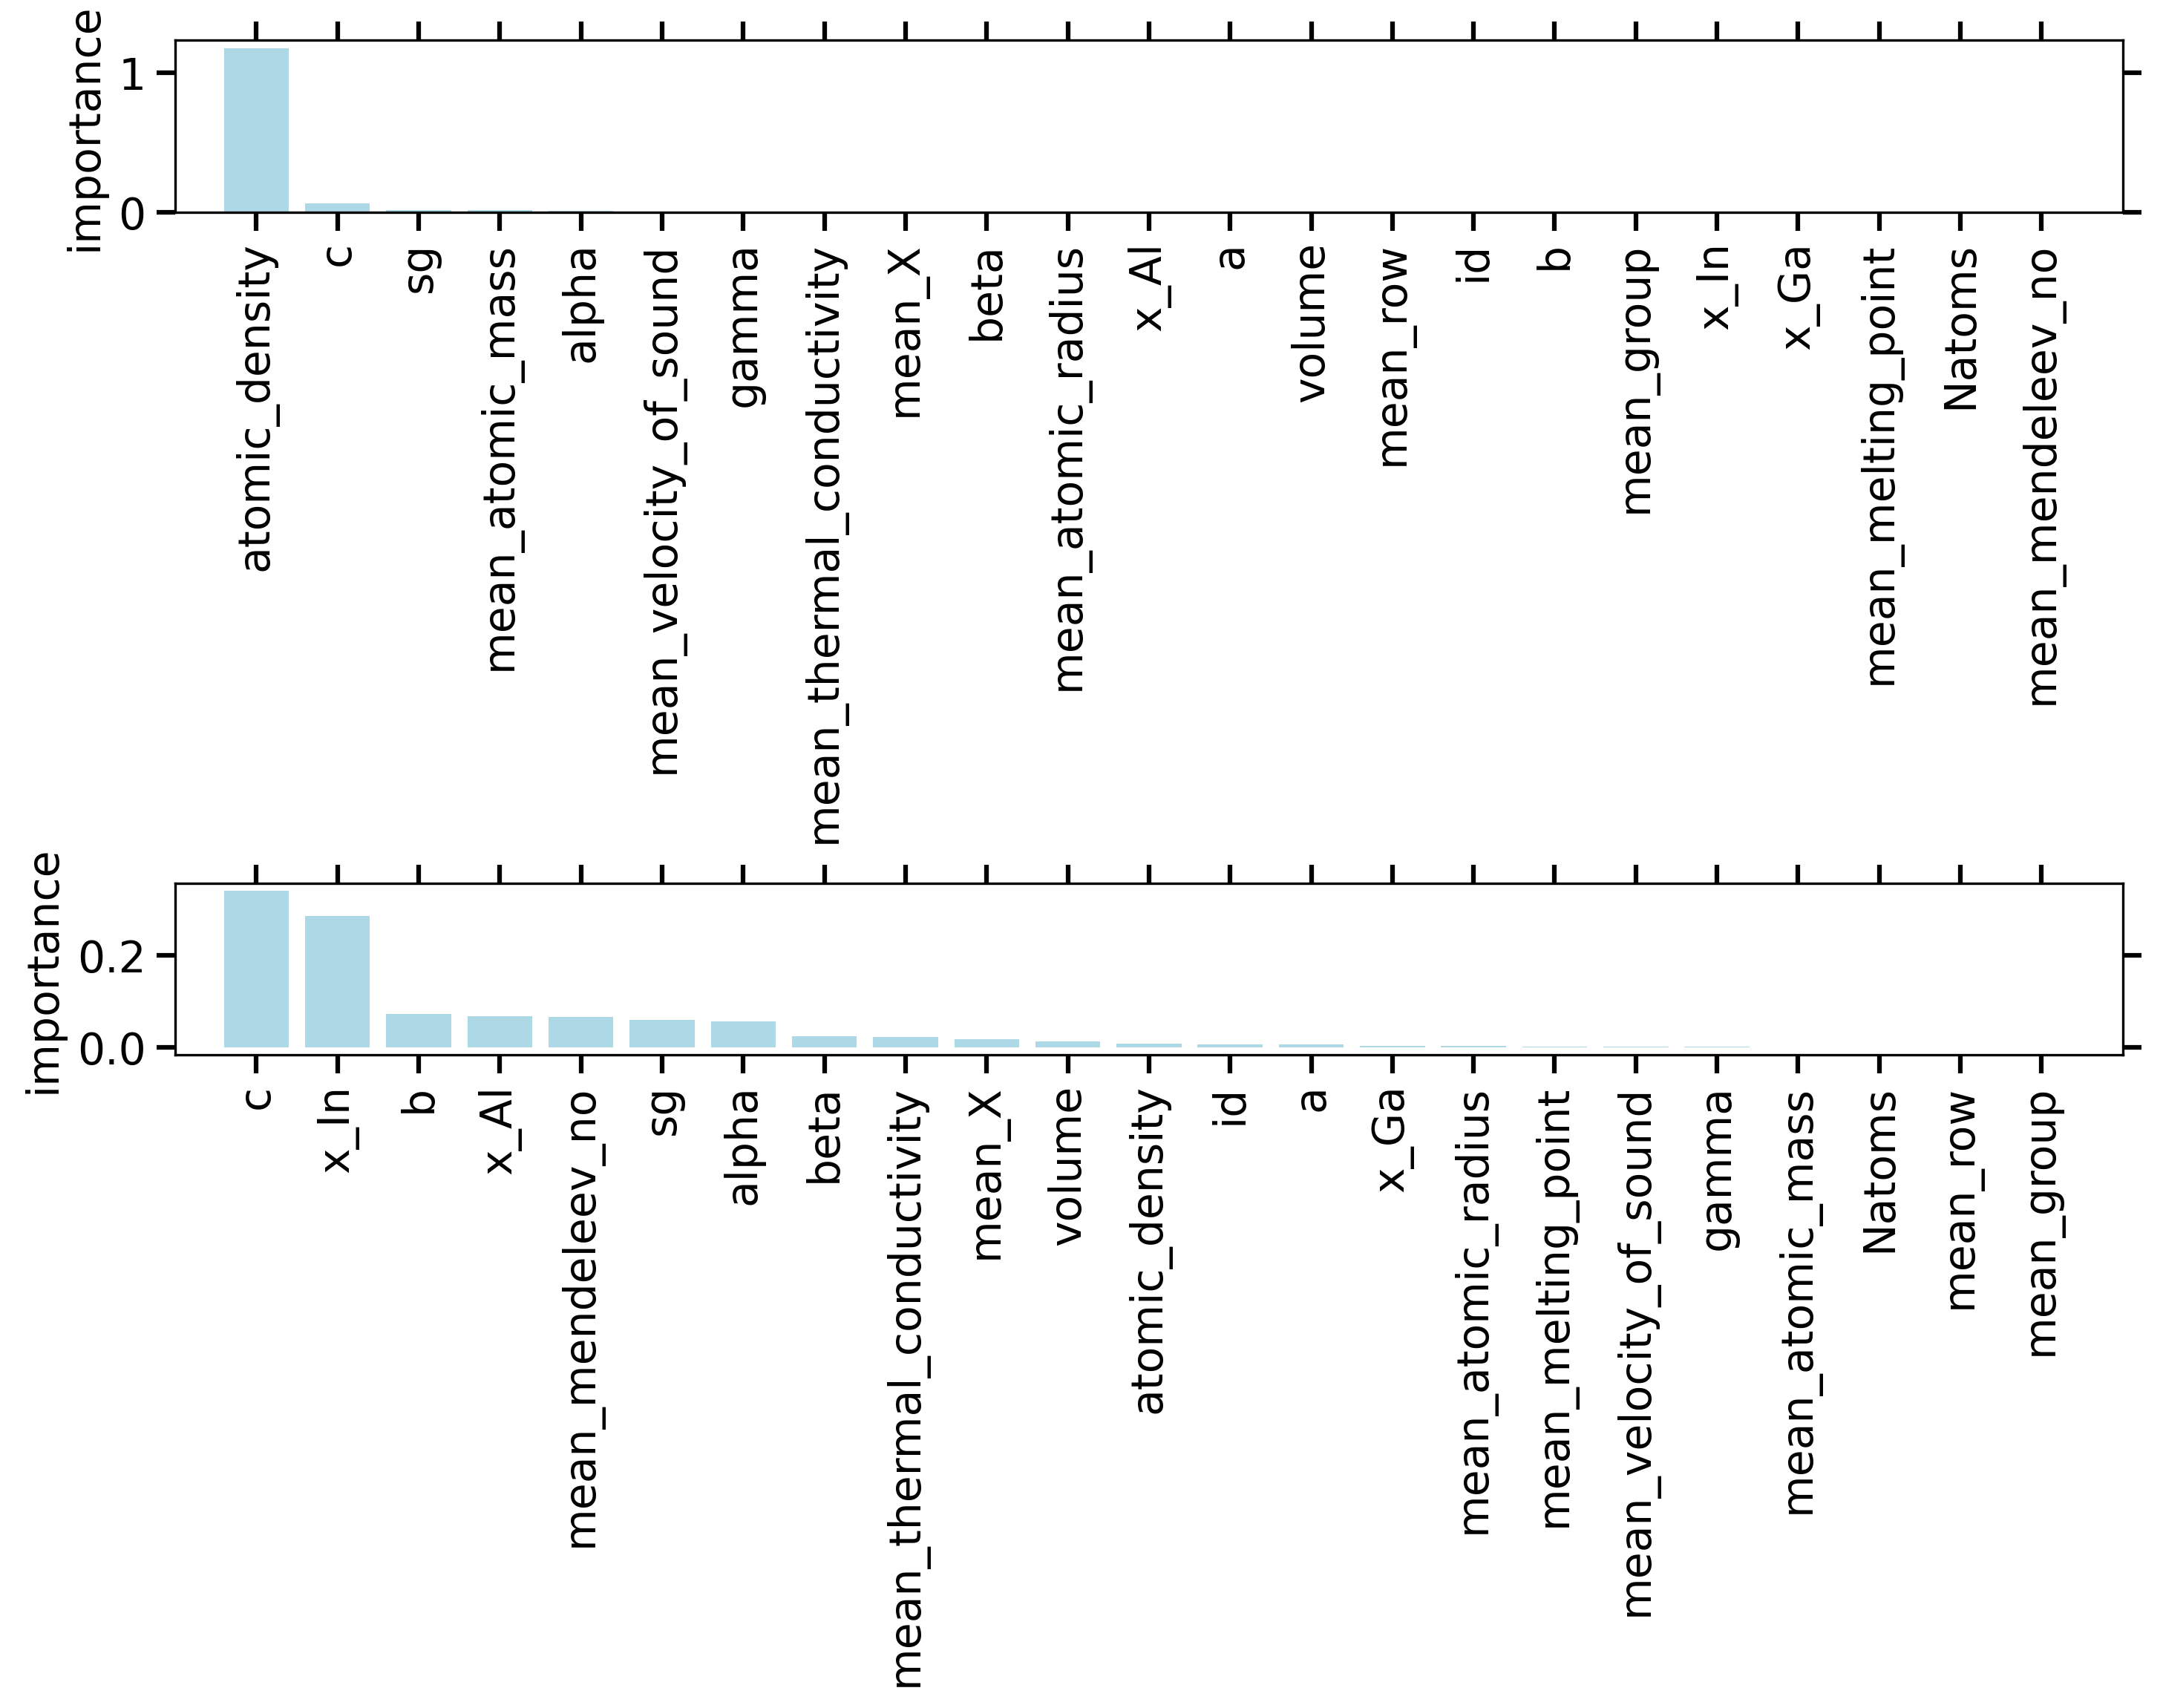

In [32]:
Eg_features_and_importances = dict(zip(good_features, results['Eg']['PFI']))
E_features_and_importances = dict(zip(good_features, results['E']['PFI']))


fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(211)
ax1 = plot_importances(Eg_features_and_importances)
ax2 = plt.subplot(212)
ax2 = plot_importances(E_features_and_importances)

## A note on feature selection
- must be done **within** CV folds

## It looks like all band gap needs is `atomic_density` and `c`. Let's compare these features for the two targets

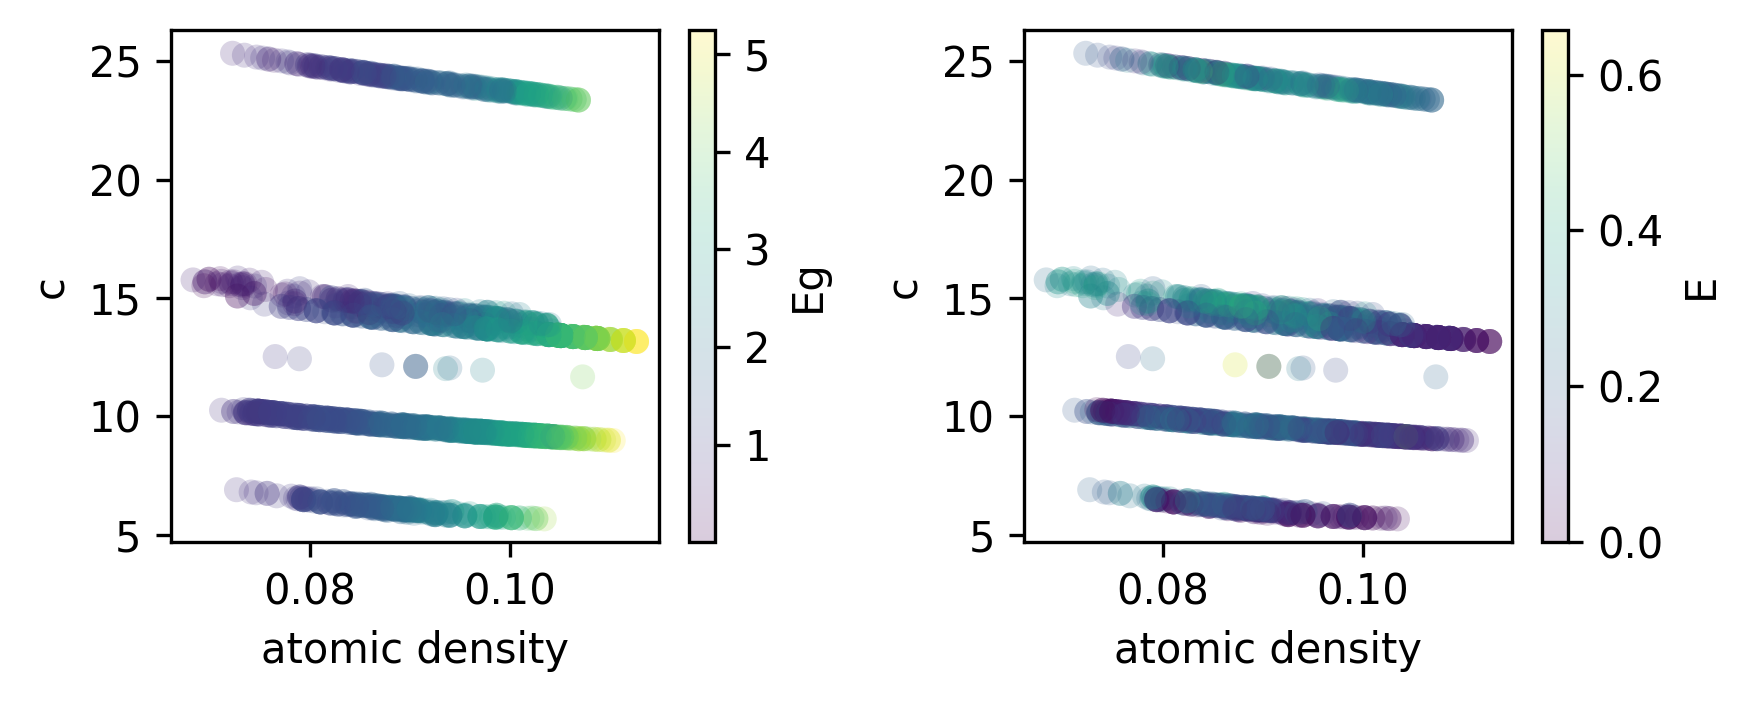

In [33]:
fig = plt.figure(figsize=(6,2.5))

ax1 = plt.subplot(121)
target = 'Eg'
x = splits[target][0][:, good_features.index('atomic_density')]
y = splits[target][0][:, good_features.index('c')]
z = splits[target][2]
ax1 = plt.scatter(x, y, c=z, cmap='viridis', alpha=0.2, lw=0)
ax1 = plt.xlabel('atomic density')
ax1 = plt.ylabel('c')
ax1 = plt.colorbar(label=target)

ax1 = plt.subplot(122)
target = 'E'
x = splits[target][0][:, good_features.index('atomic_density')]
y = splits[target][0][:, good_features.index('c')]
z = splits[target][2]
ax1 = plt.scatter(x, y, c=z, cmap='viridis', alpha=0.2, lw=0)
ax1 = plt.xlabel('atomic density')
ax1 = plt.ylabel('c')
ax1 = plt.colorbar(label=target)